In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.ticker import FuncFormatter

import seaborn as sns

from pprint import pprint

import math
import subprocess
import re

In [2]:
# original for IEEE paper
width = 3.487
height = width/1.618

# plt.rc('font', family='serif', serif='Times', size=font)
#plt.rc('text', usetex=True)  
font=7
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 7})
# plt.rc('xtick', labelsize=font)
# plt.rc('ytick', labelsize=font)
# plt.rc('legend', fontsize=font)
# plt.rc('axes', labelsize=font)


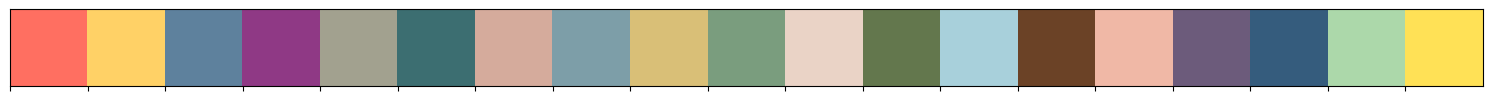

In [3]:
palette = ['#FF6F61','#FFD166','#5E819D','#8F3985','#A2A18F','#3C6E71','#D5AB9C','#7D9EA8','#D9BF77','#7A9D7E','#EAD3C6','#63774D','#A8D0DB','#6B4226','#F0B8A6','#6C5B7B','#355C7D','#ACD8AA','#FFE156']
sns.palplot(palette)
plt.show()

---

In [4]:
dgal_format = 'DIV'

In [5]:
# Select whether to read data for small matrices (and insert them in plots) or not
# include_small = 1
include_small = 0


---

In [6]:
def read_data_comparison(device, sparse_format):
    header = ['matrix','threads','csr_m','csr_n','csr_nnz',
              'time','gflops','csr_mem_footprint','W_avg','J_estimated',
              'format_name','m','n','nnz','mem_footprint',
              'compression_ratio','CSRCV_NUM_PACKET_VALS']
    
    df = pd.read_csv('./' + device + '/' + sparse_format + '.csv', header=None, names=header)
    
    # Modify 'format_name' based on 'sparse_format'
    if 'mkl_ie_f' in sparse_format:
        df['format_name'] = df['format_name'].apply(lambda x: x + '(float)')
    if 'csrrv_d' in sparse_format:
        df['format_name'] = df['format_name'].apply(lambda x: 'CSR&RV') 
    
    # need to keep matrix name only (discard full filename + .mtx extension)
    df['matrix'] = df['matrix'].apply(lambda x: x.split('/')[-1].replace('.mtx', ''))
    
    # this column is useless in "normal" formats
    df.drop('CSRCV_NUM_PACKET_VALS', axis=1)
    return df

def read_device_comparison_data(device, sparse_formats):
    # Define a list to hold all DataFrames
    all_dfs = []

    # Iterate through sparse formats and read data
    for sparse_format in sparse_formats:
        df = read_data_comparison(device, sparse_format)
        all_dfs.append(df)

    # Concatenate all DataFrames
    merged_df = pd.concat(all_dfs, ignore_index=True)

    # Print the merged DataFrame
    return merged_df


In [7]:
sparse_formats = ['aocl_optmv_d', 'csr5_d', 'csr_d', 
                  'csr_vector_lut_x86_d', 'csr_vector_x86_d', 
                  'mkl_ie_d', 'mkl_ie_f', 'sparsex_d']
lumi_comparison_formats_df = read_device_comparison_data('lumi', sparse_formats)
# print('lumi comparison formats\n', sorted(set(lumi_comparison_formats_df['format_name'])))
# lumi_comparison_formats_df

if(include_small):
    sparse_formats = ['/matrices_small/aocl_optmv_d', '/matrices_small/csr5_d', '/matrices_small/csr_d', 
                      '/matrices_small/csr_vector_lut_x86_d', '/matrices_small/csr_vector_x86_d', 
                      '/matrices_small/mkl_ie_d', '/matrices_small/mkl_ie_f', '/matrices_small/sparsex_d']
    lumi_comparison_formats_small_df = read_device_comparison_data('lumi', sparse_formats)
    # lumi_comparison_formats_small_df


In [8]:
sparse_formats = ['aocl_optmv_d', 'csr5_d', 'csr_d', 'csrrv_d', 
                  'csr_vector_lut_x86_d', 'csr_vector_x86_d', 
                  'mkl_ie_d', 'mkl_ie_f', 'sparsex_d']
icy_comparison_formats_df = read_device_comparison_data('icy', sparse_formats)
# print('icy comparison formats\n', sorted(set(icy_comparison_formats_df['format_name'])))
icy_comparison_formats_df

if(include_small):
    sparse_formats = ['/matrices_small/aocl_optmv_d', '/matrices_small/csr5_d', '/matrices_small/csr_d', '/matrices_small/csrrv_d', 
                      '/matrices_small/csr_vector_lut_x86_d', '/matrices_small/csr_vector_x86_d', 
                      '/matrices_small/mkl_ie_d', '/matrices_small/mkl_ie_f', '/matrices_small/sparsex_d']
    icy_comparison_formats_small_df = read_device_comparison_data('icy', sparse_formats)
    # icy_comparison_formats_small_df


---

In [9]:
def read_data_compression(device, sparse_format, tolerance=''):
    header = ['matrix','threads','csr_m','csr_n','csr_nnz',
              'time','gflops','csr_mem_footprint','W_avg','J_estimated',
              'format_name','m','n','nnz','mem_footprint',
              'compression_ratio','CSRCV_NUM_PACKET_VALS',
              'unbalance_time', 'unbalance_size', 'row_bits_avg', 'col_bits_avg', 'row_col_bytes_avg','trash1','trash2'
             ]
    
    df = pd.read_csv('./' + device + '/' + sparse_format + '.csv', header=None, names=header)
    
    # need to keep matrix name only (discard full filename + .mtx extension)
    df['matrix'] = df['matrix'].apply(lambda x: x.split('/')[-1].replace('.mtx', ''))
    
    if(tolerance!=''):
        df['format_name'] = df['format_name'] + '(' + df['CSRCV_NUM_PACKET_VALS'].astype(str) + ')' + ' (tolerance 1e-' + tolerance + ')'
    else:
        df['format_name'] = df['format_name'] + '(' + df['CSRCV_NUM_PACKET_VALS'].astype(str) + ')'
    
    return df

def read_device_compression_data(device, sparse_formats):
    # Define a list to hold all DataFrames
    all_dfs = []

    # Iterate through sparse formats and read data
    for sparse_format in sparse_formats:
        # If an exponential is in the format name, it means that a matrix error tolerance is being checked. 
        # Need to pass the tolerance, in order for the format_name to be formatted accordingly
        tolerance = sparse_format.split('1e-')
        if(len(tolerance)>1):
            df = read_data_compression(device, sparse_format, tolerance[1])
        else:
            df = read_data_compression(device, sparse_format)
        all_dfs.append(df)

    # Concatenate all DataFrames
    merged_df = pd.concat(all_dfs, ignore_index=True)

    # Print the merged DataFrame
    return merged_df


In [10]:
sparse_formats = [
    # 'csr_cv_stream_int_sort_abs_znp_shift', 
    'csr_cv_stream_28_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select',
    'csr_cv_fpc',
    # 'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-3',
    # 'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-6',
    # 'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-7',
    # 'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-9',
    # 'sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-12'
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select_1e-3',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select_1e-6',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select_1e-7',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select_1e-9',
    'sort_diff_lossy/csr_cv_stream_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select_1e-12'
]
lumi_compression_df = read_device_compression_data('lumi', sparse_formats)
# print('lumi compression formats\n', sorted(set(lumi_compression_df['format_name'])))
# lumi_compression_df

if(include_small):
    sparse_formats = ['/matrices_small/csr_cv_stream_int_sort_abs_znp_shift', '/matrices_small/csr_cv_fpc']
    lumi_compression_small_df = read_device_compression_data('lumi', sparse_formats)
    # lumi_compression_small_df    

In [11]:
sparse_formats = [
    # 'csr_cv_stream_int_sort_abs_znp_shift', 
    'csr_cv_stream_3_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select', 
    'csr_cv_fpc'
]
icy_compression_df = read_device_compression_data('icy', sparse_formats)
# print('icy compression formats\n', sorted(set(icy_compression_df['format_name'])))
# icy_compression_df

if(include_small):
    sparse_formats = ['/matrices_small/csr_cv_stream_int_sort_abs_znp_shift', '/matrices_small/csr_cv_fpc']
    icy_compression_small_df = read_device_compression_data('icy', sparse_formats)
    # icy_compression_small_df

---

In [12]:
# if(include_small):
#     lumi_df = pd.concat([lumi_comparison_formats_df, lumi_compression_df,
#                          lumi_comparison_formats_small_df, lumi_compression_small_df,
#                         ], ignore_index=True)
# else:
#     lumi_df = pd.concat([lumi_comparison_formats_df, lumi_compression_df
#                         ], ignore_index=True)
# lumi_df
lumi_df = pd.concat([lumi_comparison_formats_df, lumi_compression_df], ignore_index=True)

# if(include_small):
#     icy_df = pd.concat([icy_comparison_formats_df, icy_compression_df,
#                         icy_comparison_formats_small_df, icy_compression_small_df,
#                        ], ignore_index=True)
# else:
#     icy_df = pd.concat([icy_comparison_formats_df, icy_compression_df
#                        ], ignore_index=True)
# icy_df
icy_df = pd.concat([icy_comparison_formats_df, icy_compression_df], ignore_index=True)


if(include_small):
    lumi_small_df = pd.concat([lumi_comparison_formats_small_df, lumi_compression_small_df], ignore_index=True)
    icy_small_df = pd.concat([icy_comparison_formats_small_df, icy_compression_small_df], ignore_index=True) 


---

In [13]:
# I want to replace the original format names. Do it in tuples (old,new)

def apply_replacements(df, replacements):
    for replacement in replacements:
        old_value, new_value = replacement
        df['format_name'] = df['format_name'].str.replace(old_value, new_value)

# LUMI
replacements =  [('AOCL_OPTMV',            'AMD-AOCL'),
                 ('CSR5',                  'CSR5'),
                 ('Custom_CSR_BV_LUT_x86', 'Dictionary(custom)'),
                 ('Custom_CSR_BV_x86',     'Balanced-Vectorized-CSR'),
                 ('Custom_CSR_B',          'Balanced-CSR'),
                 ('MKL_IE(float)',         'MKL(32-bits)'),
                 ('MKL_IE',                'MKL(64-bits)'),
                 ('SparseX',               'SparseX'),
                 ('CSR_CVS',               dgal_format),
                 ('CSR_CV',                'FPC')
                ]
apply_replacements(lumi_df, replacements)
if(include_small):
    apply_replacements(lumi_small_df, replacements)

# ICY
replacements =  [('AOCL_OPTMV',            'AMD-AOCL'),
                 ('CSR5',                  'CSR5'),
                 ('Custom_CSR_BV_LUT_x86', 'Dictionary(custom)'),
                 ('Custom_CSR_BV_x86',     'Balanced-Vectorized-CSR'),
                 ('Custom_CSR_B',          'Balanced-CSR'),
                 ('CSR&RV',                'Dictionary(CSR&RV)'),
                 ('MKL_IE(float)',         'MKL(32-bits)'),
                 ('MKL_IE',                'MKL(64-bits)'),
                 ('SparseX',               'SparseX'),
                 ('CSR_CVS',               dgal_format),
                 ('CSR_CV',                'FPC')
                ]
apply_replacements(icy_df, replacements)
if(include_small):
    apply_replacements(icy_small_df, replacements)


---
# Performance of each format for each matrix separately

In [14]:
def plot_barplot_per_matrix(device_df, device, formats_to_plot):
    # Sort matrices by memory footprint (in CSR representation) and then plot each matrix separate
    device_df.sort_values(by='csr_mem_footprint', ascending=True, inplace=True)
    matrix_values = device_df['matrix'].unique()

    # Iterate through each 'matrix' and plot the barplot
    for matrix_value in matrix_values:
        
        # Filter the DataFrame for the specific 'matrix' and the specified formats
        filtered_df = device_df[(device_df['matrix'] == matrix_value) & (device_df['format_name'].isin(formats_to_plot))]

        if filtered_df.empty:
            print(f"No data found for matrix '{matrix_value}' and the specified formats.")
            return

        # Create a custom color palette based on the provided format_color_mapping
        # custom_palette = [format_color_mapping[format_name] for format_name in formats_to_plot]

        # Create the barplot
        sns.barplot(x='format_name', y='gflops', data=filtered_df, order=formats_to_plot)

        plt.title('Performance of Matrix "%s" on device "%s"' % (matrix_value, device))
        plt.xlabel('Format Name')
        plt.ylabel('Performance (GFLOPs)')

        # Rotate x-axis labels for better visibility if needed
        plt.xticks(rotation=90)

        # Save the plot as a PDF
        plt.tight_layout()
        fig_name = './plots/barplots_per_matrix/'+ device  +'/barplot_matrix_%s.pdf' % (matrix_value)
        plt.savefig(fig_name)    
        plt.close()
        subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
        subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])
    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(1.5*width,1.5*height))

normal_formats = ['CSR5', 'SparseX', 'Dictionary(custom)', 'MKL(64-bits)', 'MKL(32-bits)', ]

compression_formats = [
                       'FPC(64)',      'FPC(128)',     'FPC(256)',     'FPC(512)', 
                       'FPC(1024)',    'FPC(2048)',    'FPC(4096)',    'FPC(8192)',
                       'FPC(16384)',
                       'FPC(32768)',   'FPC(65536)',   'FPC(131072)',
                       'FPC(262144)',  'FPC(524288)',  'FPC(1048576)', 'FPC(2097152)',
                       'FPC(4194304)', 'FPC(8388608)', 'FPC(16777216)',

                       dgal_format + '(64)',      dgal_format + '(128)',     dgal_format + '(256)',     dgal_format + '(512)', 
                       dgal_format + '(1024)',    dgal_format + '(2048)',    dgal_format + '(4096)',    dgal_format + '(8192)',
                       dgal_format + '(16384)',
                       dgal_format + '(32768)',   dgal_format + '(65536)',   dgal_format + '(131072)',
                       dgal_format + '(262144)',  dgal_format + '(524288)',  dgal_format + '(1048576)', dgal_format + '(2097152)',
                       dgal_format + '(4194304)', dgal_format + '(8388608)', dgal_format + '(16777216)'

                        ]
formats_to_plot = normal_formats + compression_formats

if(1):
    plot_barplot_per_matrix(lumi_df, 'lumi', formats_to_plot)
    plot_barplot_per_matrix(icy_df,  'icy', formats_to_plot)


---

---
# Add an "average" and a "geomean" row for each format, which groups all matrices in one measurement

In [15]:
def calc_average(df):
    # Calculate the average gflops for each format_name
    average_gflops = df.groupby('format_name')['gflops'].mean()

    # Create a new DataFrame for the average values
    average_df = pd.DataFrame({'matrix': ['Average'] * len(average_gflops),
                               'format_name': average_gflops.index,
                               'gflops': average_gflops.values,
                               'csr_mem_footprint': [10000] * len(average_gflops)})

    # Append the average information to the original DataFrame
    new_df = pd.concat([df, average_df], ignore_index=True)
    # new_df = new_df[new_df['matrix']=='Average'][['gflops','format_name']]
    # new_df[new_df['format_name'].isin(formats_to_plot)]
    return new_df

def calc_geomean(df):
    # Calculate the geomean gflops for each format_name
    geomean_gflops = df.groupby('format_name')['gflops'].apply(lambda x: np.exp(np.mean(np.log(x))))

    # Create a new DataFrame for the average values
    geomean_df = pd.DataFrame({'matrix': ['Geomean'] * len(geomean_gflops),
                               'format_name': geomean_gflops.index,
                               'gflops': geomean_gflops.values,
                               'csr_mem_footprint': [10000] * len(geomean_gflops)})

    # Append the average information to the original DataFrame
    new_df = pd.concat([df, geomean_df], ignore_index=True)
    # new_df = new_df[new_df['matrix']=='Average'][['gflops','format_name']]
    # new_df[new_df['format_name'].isin(formats_to_plot)]
    return new_df


lumi_df_ext_avg = calc_average(lumi_df)
icy_df_ext_avg  = calc_average(icy_df)
lumi_df_ext_geomean = calc_geomean(lumi_df)
icy_df_ext_geomean  = calc_geomean(icy_df)

if(include_small):
    lumi_small_df_ext_avg = calc_average(lumi_small_df)
    icy_small_df_ext_avg  = calc_average(icy_small_df)
    lumi_small_df_ext_geomean = calc_geomean(lumi_small_df)
    icy_small_df_ext_geomean  = calc_geomean(icy_small_df)


In [16]:
def print_per_format(df, device, what, formats):
    print(what + ' performance for "' + device + '"')
    print(df[(df['format_name'].isin(formats)) & (df['matrix']==what)]
          [['format_name','gflops']]
          .sort_values(by='gflops',ascending=True)
          .to_string(index=False),'\n')    

formats = ['FPC(16384)', 'Dictionary(custom)', 'CSR5', 'SparseX', 'AMD-AOCL', 'MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)']
print_per_format(lumi_df_ext_avg, 'lumi', 'Average', formats)
print_per_format(lumi_df_ext_geomean, 'lumi', 'Geomean', formats)

formats = ['FPC(16384)', 'Dictionary(CSR&RV)', 'CSR5', 'SparseX', 'AMD-AOCL', 'MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)']
print_per_format(icy_df_ext_avg, 'icy', 'Average', formats)
print_per_format(icy_df_ext_geomean, 'icy', 'Geomean', formats)


Average performance for "lumi"
       format_name    gflops
        FPC(16384) 14.099511
          AMD-AOCL 16.165085
Dictionary(custom) 28.164823
              CSR5 29.355174
      MKL(64-bits) 30.774565
           SparseX 36.641849
      MKL(32-bits) 57.373708
        DIV(16384) 59.637869 

Geomean performance for "lumi"
       format_name    gflops
Dictionary(custom) 10.662100
          AMD-AOCL 13.327775
        FPC(16384) 13.869629
              CSR5 28.944767
      MKL(64-bits) 30.269854
           SparseX 35.055934
      MKL(32-bits) 55.549926
        DIV(16384) 56.933462 

Average performance for "icy"
       format_name    gflops
        FPC(16384)  3.894652
Dictionary(CSR&RV)  7.404106
          AMD-AOCL  9.804441
              CSR5 10.374141
      MKL(64-bits) 10.753559
           SparseX 12.230286
        DIV(16384) 14.588263
      MKL(32-bits) 17.664558 

Geomean performance for "icy"
       format_name    gflops
        FPC(16384)  3.866490
Dictionary(CSR&RV)  5.113651
  

---
# Performance of selected formats (including "lossless" method for specific packet size), all matrices in one plot

In [17]:
format_color_mapping = {
    'FPC(16384)' :  palette[0],
    'Dictionary(CSR&RV)'  :  palette[1],
    'Dictionary(custom)'  :  palette[1],
    'CSR5'        :  palette[2],
    'SparseX'     :  palette[3],
    'MKL(64-bits)':  palette[4],
    'MKL(32-bits)':  palette[5],
    dgal_format + '(16384)' :  palette[6],
    'AMD-AOCL'    : palette[7]
}

def plot_barplot_device(device_df, device, formats_to_plot, special=''):
    # Sort matrices by memory footprint (in CSR representation) and then plot each matrix separate
    device_df.sort_values(by='csr_mem_footprint', ascending=True, inplace=True)
    matrix_values = device_df['matrix'].unique()
    
    # Filter the DataFrame for the specified matrices and the specified formats
    filtered_df = device_df[(device_df['matrix'].isin(matrix_values)) & (device_df['format_name'].isin(formats_to_plot))]

    if filtered_df.empty:
        print("No data found for the specified matrices and formats.")
        return

    # Create a mapping of matrix names to IDs
    matrix_id_mapping = {matrix: f'({i+1})' for i, matrix in enumerate(matrix_values)}
    if('Average' in matrix_id_mapping.keys()):
        matrix_id_mapping['Average'] = 'avg'
    if('Geomean' in matrix_id_mapping.keys()):
        matrix_id_mapping['Geomean'] = 'geo\nmean'

    # Replace matrix names with IDs
    filtered_df['matrix_id'] = filtered_df['matrix'].map(matrix_id_mapping)

    # plt.figure(figsize=(24, 16))  # Adjust the figure size as needed
    ax = sns.barplot(x='matrix_id', y='gflops', hue='format_name', data=filtered_df, 
                     palette=format_color_mapping, hue_order=formats_to_plot)

    plt.xlabel('Matrix ID')
    ax.xaxis.set_label_coords(0.48, -0.15)  # Adjust the y-coordinate as needed
    plt.ylabel('Performance (GFLOPs)')

    # Rotate x-axis labels for better visibility if needed
    plt.xticks(rotation=0)
    
    y_limit = 110
    if(device == 'lumi'):
        ax.set(ylim=(0,y_limit))
    
    for p in ax.patches:
        if p.get_height() > y_limit:
            print(p.get_height())
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() - 0.35, y_limit-5), ha='center', fontsize=6.5)

    # Move the legend to the top and display in one line
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, frameon=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.14), ncol=len(formats_to_plot), frameon=False, fontsize=6.5)
        
    # Save the plot as a PDF
    plt.tight_layout()
    # if(include_small):
    #     extra='_with_small'
    # else:
    #     extra=''
    extra=''
    fig_name = './plots/performance_comparison_%s%s%s.pdf' % (device,extra,special)
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])



####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(2*width,1*height))

# Set the order that formats will be plotted
formats_to_plot = ['FPC(16384)', 'Dictionary(custom)', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)']
# formats_to_plot = ['AMD-AOCL', 'MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)']
# plot_barplot_device(lumi_df, 'lumi', formats_to_plot)
# plot_barplot_device(lumi_df_ext_avg, 'lumi', formats_to_plot)
plot_barplot_device(lumi_df_ext_geomean, 'lumi', formats_to_plot, '_lossless')

formats_to_plot = ['FPC(16384)', 'Dictionary(CSR&RV)', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)']
# formats_to_plot = ['Dictionary(custom)', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)']
# plot_barplot_device(icy_df,  'icy', formats_to_plot)
# plot_barplot_device(icy_df_ext_avg,  'icy', formats_to_plot)
plot_barplot_device(icy_df_ext_geomean,  'icy', formats_to_plot, '_lossless')


166.952462
149.680748


# Comparison of performance for small matrices (on lumi only)

In [18]:
if(include_small):
    formats_to_print = ['AMD-AOCL', 'MKL(64-bits)', 'MKL(32-bits)', 'DIV(16384)']
    for fn in formats_to_print:
        print(fn)
        filtered_df = lumi_small_df_ext_geomean[lumi_small_df_ext_geomean['format_name'] == fn][['matrix', 'csr_mem_footprint', 'gflops']]
        filtered_df = filtered_df.round({'gflops':0, 'csr_mem_footprint':0})
        print(filtered_df)

---
# Comparison of different packet sizes for "lossless" method

In [19]:
def convert_to_human_readable(input_number):
    # Convert the input to a numerical value
    try:
        number = float(input_number)
    except ValueError:
        raise ValueError("Input is not a valid number.")

    suffixes = ['', 'K', 'M']
    
    for suffix in suffixes:
        if number >= 1024:
            number /= 1024
        else:
            break

    if number.is_integer():
        return f'{int(number)}{suffix}'
    else:
        return f'{number:.1f}{suffix}'

# Function to extract packet size value from the xtick label
def extract_packet_size(label):
    match = re.search(r'\((.*?)\)', label)
    if match:
        return convert_to_human_readable(match.group(1))
    else:
        return label

def plot_packet_size(df, device, formats_to_plot, plot_type):
    if(plot_type == 'violin'):
        ax = sns.violinplot(x='format_name', y='gflops', data=df, palette=palette,
                            fliersize = .3, linewidth=.5, width=.8, dodge=True, order=formats_to_plot)
    elif(plot_type == 'box'):
        ax = sns.boxplot(x='format_name', y='gflops', data=df, palette=palette,
                         fliersize = .3, linewidth=.5, width=.8, dodge=True, order=formats_to_plot)
    
    # Set x-axis labels based on packet size value
    xticks_original = ax.get_xticklabels()
    for xtick in xticks_original:
        xtick.set_text(extract_packet_size(xtick.get_text()))
    ax.set_xticklabels(xticks_original)

    plt.xlabel('Packet Size')
    plt.ylabel('Performance (GFLOPs)')

    # Rotate x-axis labels for better visibility if needed
    plt.xticks(rotation=45)

    # if(include_small):
    #     extra='_with_small'
    # else:
    #     extra=''
    extra=''

    # Save the plot as a PDF
    plt.tight_layout()
    fig_name = './plots/packet_size_perf_' + device + '_' + plot_type + extra + '.pdf'
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])

    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(width,0.8*height))

formats_to_plot = [dgal_format + '(64)', dgal_format + '(128)', dgal_format + '(256)', dgal_format + '(512)', dgal_format + '(1024)', dgal_format + '(2048)',
                   dgal_format + '(4096)', dgal_format + '(8192)', dgal_format + '(16384)', dgal_format + '(32768)', dgal_format + '(65536)', 
                   dgal_format + '(131072)', dgal_format + '(262144)', dgal_format + '(524288)', dgal_format + '(1048576)', dgal_format + '(2097152)',
                   dgal_format + '(4194304)', dgal_format + '(8388608)', dgal_format + '(16777216)']

plot_packet_size(lumi_df, 'lumi', formats_to_plot, plot_type = 'box')
plot_packet_size(icy_df, 'icy', formats_to_plot, plot_type = 'box')


---
# Performance vs Unique Values Fraction


In [20]:
# Read the CSV file with matrix features
matrix_features_df = pd.read_csv('matrix_features.csv', header=0, sep='\t', index_col=0)
matrix_features_df = matrix_features_df.drop(['min', 'max', 'average'], axis=1)

# The dataframe is in transpose mode, therefore I need it in Transpose mode
# Transpose the DataFrame
matrix_features_df = matrix_features_df.T.reset_index(drop=False).rename(columns={'index': 'matrix'})

# Print the desired DataFrame
# for i in range(len(matrix_features_df.columns)):
#     print(i, matrix_features_df.columns[i])

# Filter only desired feature (fraction of unique values in total nonzeros of matrix)
uvf_df = matrix_features_df[['matrix', 'vals unique fraction']].reset_index(drop=True)
uvf_df.sort_values(by='vals unique fraction', ascending=True, inplace=True)


# now try to group all matrices in one more general category (in the described range for unique vals fraction)
def set_category(x, cat_list):
    for index in range(len(cat_list)):
        cat = cat_list[index]
        cat_min = float(cat.strip('[').strip(']').split(' - ')[0].strip('%'))/100
        cat_max = float(cat.strip('[').strip(']').split(' - ')[1].strip('%'))/100
        # print(cat_min, cat_max,'->\t->', x)
        if(x>cat_min and x<=cat_max):
            # what = '['+ str(cat_min*100) +'% - '+ str(cat_max*100) + '%]'
            # print(what)
            # return what            
            return cat_list[index]

# ranges_uvf = ['[1.0e-07 - 1.0e-05]',
#               '[1.0e-05 - 1.0e-03]',
#               '[1.0e-03 - 1.0e-00]']

ranges_uvf = ['[0% - 0.001%]',
              '[0.001% - 10%]',
              '[10% - 30%]',
              '[30% - 100%]']

uvf_df['uvf_categ'] = uvf_df.apply(lambda row: set_category(row['vals unique fraction'], ranges_uvf), axis=1)
print('Matrices in each unique values fraction range')
print(uvf_df['uvf_categ'].value_counts())

# now combine the dataframes, by adding a new column in the existing lumi and icy dataframes
lumi_ext_geomean_uvf_df = pd.merge(lumi_df_ext_geomean, uvf_df, on='matrix', how='left')
icy_ext_geomean_uvf_df = pd.merge(icy_df_ext_geomean, uvf_df, on='matrix', how='left')


Matrices in each unique values fraction range
uvf_categ
[30% - 100%]      12
[0.001% - 10%]     9
[10% - 30%]        5
[0% - 0.001%]      3
Name: count, dtype: int64


In [21]:
format_color_mapping = {
    'FPC(16384)' :  palette[0],
    'Dictionary(CSR&RV)'  :  palette[1],
    'Dictionary(custom)'  :  palette[1],
    'CSR5'        :  palette[2],
    'SparseX'     :  palette[3],
    'MKL(64-bits)':  palette[4],
    'MKL(32-bits)':  palette[5],
    dgal_format + '(16384)' :  palette[6],
}

# Function to extract tolerance value from the xtick label
def extract_tolerance(label):
    match = re.search(r'\(tolerance (.*?)\)', label)
    if match:
        return match.group(1)
    else:
        if('MKL' in label):
            return ''.join(['MKL\n', label.split('MKL')[1]])
        elif(dgal_format in label):
            return 'Lossless'
        return label

def plot_uvf_perf(df, device, ranges_uvf, formats_to_plot, variable, plot_type):
    # Sort matrices by memory footprint (in CSR representation) and then plot each matrix separate
    df.sort_values(by='csr_mem_footprint', ascending=True, inplace=True)
    matrix_values = df['matrix'].unique()
    
    # Filter the DataFrame for the specified matrices and the specified formats
    filtered_df = df[(df['matrix'].isin(matrix_values)) & (df['format_name'].isin(formats_to_plot))]

    if filtered_df.empty:
        print("No data found for the specified matrices and formats.")
        return
    
    if(plot_type == 'violin'):
        ax = sns.violinplot(x='uvf_categ', y=variable, data=df, palette=format_color_mapping,
                            fliersize = .3, linewidth=.5, width=.8, dodge=True, order=ranges_uvf,
                            hue = 'format_name', hue_order=formats_to_plot)
    elif(plot_type == 'box'):
        ax = sns.boxplot(x='uvf_categ', y=variable, data=df, palette=format_color_mapping,
                         fliersize = .3, linewidth=.5, width=.8, dodge=True, order=ranges_uvf,
                         hue = 'format_name', hue_order=formats_to_plot)
    
    # Set x-axis labels based on tolerance value
    xticks_original = ax.get_xticklabels()
    for xtick in xticks_original:
        xtick.set_text(extract_tolerance(xtick.get_text()))
    ax.set_xticklabels(xticks_original)

    plt.xlabel('Unique Values Fraction')
    if(variable == 'gflops'):
        plt.ylabel('Performance (GFLOPs)')

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, frameon=False, fontsize=6.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, frameon=False, fontsize=6)

    # if(include_small):
    #     extra='_with_small'
    # else:
    #     extra=''
    extra=''
  
    # Save the plot as a PDF
    plt.tight_layout()
    fig_name = './plots/'+ 'uvf_perf_'+ device + '_' + plot_type + extra + '.pdf'
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])

    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(width,1.2*height))

formats_to_plot = ['FPC(16384)', 'Dictionary(custom)', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)']
plot_uvf_perf(lumi_ext_geomean_uvf_df, 'lumi', ranges_uvf, formats_to_plot, 'gflops', plot_type = 'box')

formats_to_plot = ['FPC(16384)', 'Dictionary(CSR&RV)', 'CSR5', 'SparseX', 'MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)']
plot_uvf_perf(icy_ext_geomean_uvf_df, 'icy', ranges_uvf, formats_to_plot, 'gflops', plot_type = 'box')


---
---
# Performance and Errors (matrix and spmv) of "lossy" methods
## we have collected measurements for different matrix error tolerance for 3, 6, 7, 9, 12 bits on lumi

In [22]:
# Function to convert float to scientific notation
def float_to_scientific(x):
    if(x==0):
        return 0.0000e-12
    else:
        return '{:.4e}'.format(x)

# Function to extract the exponent from a scientific notation string
def extract_exponent(sci_notation):
    # Split the string at 'e' to get the exponent part
    parts = str(sci_notation).split('e')
    if len(parts) == 2:
        return math.log10(float(sci_notation))
    else:
        return -12

def error_parsing(sparse_format):
    # if not lossy format tested (mkl-32) no need to use extra in filename of awk
    # else use the specific awk file, that filters only '16384' packet size values
    extra=''
    if('e-' in sparse_format):
        extra = '_16384'

    # thanks dgal for the awk magic!!
    output = subprocess.check_output(['awk', '-f', 'parse_cv_errors'+extra+'.awk', sparse_format + '.out'])
    output_lines = output.decode('utf-8').split('\n')

    # Remove the last empty line if exists
    if output_lines[-1] == '':
        output_lines.pop()

    # Convert the output to a DataFrame    
    # awk returns errors separated by \t, need to parse it and pass it to a pandas dataframe
    header_names = ['Matrix MAE','Matrix max AE','Matrix MSE','Matrix MAPE','Matrix SMAPE',
                    'SpMV MAE',  'SpMV max AE',  'SpMV MSE',  'SpMV MAPE',  'SpMV SMAPE']
    
    error_df = pd.DataFrame([line.split('\t') for line in output_lines], columns=header_names)
    error_df[header_names] = error_df[header_names].astype(float)
    
    header_names = ['Matrix SMAPE', 'SpMV SMAPE']
    # Need to extract exponent in order to plot violin plot with exponents only 
    # (if using log scale on y axis it, everything is messed up)
    for variable in header_names:
        error_df[variable + ' scientific'] = error_df[variable].apply(float_to_scientific)
        error_df[variable + ' exponent'] = error_df[variable+ ' scientific'].apply(extract_exponent)
    matrix_error_tolerance = sparse_format.split('1e-')
    if(len(matrix_error_tolerance) > 1):
        error_df['Matrix Error Tolerance'] = '1e-'+matrix_error_tolerance[1]
    else:
        if('mkl_ie_f' in sparse_format):
            error_df['Matrix Error Tolerance'] = 'MKL(32-bits)'
        elif('mkl_ie_d' in sparse_format):
            error_df['Matrix Error Tolerance'] = 'MKL(64-bits)'
        else:
            error_df['Matrix Error Tolerance'] = dgal_format + '(16384)'
    return error_df

# files that contain 
# prefix='./lumi/sort_diff_lossy/csr_cv_stream_int_sort_abs_znp_shift_1e-'
prefix='./lumi/sort_diff_lossy/csr_cv_stream_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select_1e-'
sparse_formats = [prefix+'12', prefix+'9', prefix+'7', prefix+'6', prefix+'3', 
                  './lumi/mkl_ie_f',
                  './lumi/mkl_ie_d',
                  # './lumi/csr_cv_stream_int_sort_abs_znp_shift',
                  './lumi/csr_cv_stream_28_int_sort_abs_nzp_shift_force_row_1_byte_r0_select_dense_select'
                 ]
all_dfs = []
for sparse_format in sparse_formats:
    all_dfs.append(error_parsing(sparse_format))

matrix_and_spmv_error = pd.concat(all_dfs)
matrix_and_spmv_error

,Matrix MAE,Matrix max AE,Matrix MSE,Matrix MAPE,Matrix SMAPE,SpMV MAE,SpMV max AE,SpMV MSE,SpMV MAPE,SpMV SMAPE,Matrix SMAPE scientific,Matrix SMAPE exponent,SpMV SMAPE scientific,SpMV SMAPE exponent,Matrix Error Tolerance
0,2.579310e-17,1.952920e-16,2.466500e-33,2.000110e-11,1.000050e-11,9.695510e-14,8.031350e-13,2.188800e-26,1.409150e-11,7.045730e-12,1.0001e-11,-10.999957,7.0457e-12,-11.152076,1e-12
1,4.558450e-08,4.262480e-05,9.045520e-14,4.561440e-11,2.280720e-11,5.350140e-07,9.606780e-05,5.880250e-12,2.594920e-08,1.297460e-08,2.2807e-11,-10.641932,1.2975e-08,-7.886893,1e-12
2,1.343840e-13,5.576340e-11,3.346500e-25,4.997790e-11,2.498900e-11,1.156160e-12,4.888530e-11,7.449170e-24,3.525280e-10,1.762640e-10,2.4989e-11,-10.602251,1.7626e-10,-9.753846,1e-12
3,1.148120e+04,2.458580e+08,4.108720e+11,2.466630e-11,1.254190e-11,1.004850e+05,1.415860e+08,3.170730e+12,1.937710e+05,2.614630e-02,1.2542e-11,-10.901633,2.6146e-02,-1.582595,1e-12
4,8.063140e-09,5.696200e-07,9.782670e-16,4.952400e-11,2.476200e-11,5.793190e-08,5.002550e-07,7.887910e-15,1.131010e+01,7.330390e-04,2.4762e-11,-10.606214,7.3304e-04,-3.134872,1e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.442360e-15,2.131630e-14,3.456550e-29,5.745010e-14,2.872510e-14,0.0,-12.000000,2.8725e-14,-13.541740,DIV(16384)
25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.575450e-14,8.731150e-11,5.626020e-26,1.742610e-11,8.713050e-12,0.0,-12.000000,8.7130e-12,-11.059832,DIV(16384)
26,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.250250e-03,5.482100e+01,2.010100e-02,8.368080e+07,1.659450e-02,0.0,-12.000000,1.6595e-02,-1.780023,DIV(16384)
27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.098660e-16,3.703580e-14,4.562930e-31,1.062000e+01,8.893710e+00,0.0,-12.000000,8.8937e+00,0.949082,DIV(16384)


In [23]:
format_color_mapping = {
    'MKL(64-bits)': palette[4],
    'MKL(32-bits)': palette[5],
    dgal_format + '(16384)' :  palette[6],
    '1e-3' :  palette[7],
    '1e-6' :  palette[8],
    '1e-7' :  palette[9],
    '1e-9' :  palette[10], 
    '1e-12' : palette[11],
}

# Function to extract tolerance value from the xtick label
def extract_tolerance(label):
    match = re.search(r'\(tolerance (.*?)\)', label)
    if match:
        return match.group(1)
    else:
        if('MKL' in label):
            return ''.join(['MKL\n', label.split('MKL')[1]])
        elif(dgal_format in label):
            return 'Lossless'
        return label
    
    
# Function to format y-axis labels as integers
def format_y_axis_ticks(value, _):
    return f'{int(value):d}'

def plot_lossy_error(df, variable, unique_error_tolerances, plot_type):
    # Get unique values of 'Matrix Error Tolerance' and reverse the order
    
    if(plot_type == 'violin'):
        ax = sns.violinplot(x='Matrix Error Tolerance', y=variable, data=df, palette=format_color_mapping,
                            fliersize = .3, linewidth=.5, width=.8, dodge=True, order=unique_error_tolerances)
    elif(plot_type == 'box'):
        ax = sns.boxplot(x='Matrix Error Tolerance', y=variable, data=df, palette=format_color_mapping,
                         fliersize = .3, linewidth=.5, width=.8, dodge=True, order=unique_error_tolerances)

    # Set x-axis labels based on tolerance value
    xticks_original = ax.get_xticklabels()
    for xtick in xticks_original:
        xtick.set_text(extract_tolerance(xtick.get_text()))
    ax.set_xticklabels(xticks_original)

    plt.xlabel('Matrix Error Tolerance')
    plt.ylabel(variable + ' (%)')
    
    ax.xaxis.set_label_coords(0.7, -0.17)  # Adjust the y-coordinate as needed
    plt.annotate('|_____________________________________________________________________________|', 
                 xy=(4.98, -0.15), xycoords=ax.get_xaxis_transform(), ha='center', fontsize=3)
    
    if('exponent' not in variable):
        plt.yscale('log')  # Set y-axis scale to log (only when printing boxplot)
    else:
        # Set the y-axis labels to display as integers
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis_ticks))

    # Save the plot as a PDF
    plt.tight_layout()
    fig_name = './plots/lossy_'+variable.replace(' ','_') + '_' + plot_type + '.pdf'
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])
    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(width,0.8*height))

unique_error_tolerances = ['MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)', '1e-12', '1e-9', '1e-7', '1e-6', '1e-3']
plot_lossy_error(matrix_and_spmv_error, 'Matrix SMAPE', unique_error_tolerances, plot_type = 'box')
# plot_lossy_error(matrix_and_spmv_error, 'Matrix SMAPE' + ' exponent', unique_error_tolerances, plot_type = 'violin')

unique_error_tolerances = ['MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)', '1e-12', '1e-9', '1e-7', '1e-6', '1e-3']
plot_lossy_error(matrix_and_spmv_error, 'SpMV SMAPE', unique_error_tolerances, plot_type = 'box')
# plot_lossy_error(matrix_and_spmv_error, 'SpMV SMAPE' + ' exponent', unique_error_tolerances, plot_type = 'violin')


In [24]:
format_color_mapping = {
    'MKL(64-bits)': palette[4],
    'MKL(32-bits)': palette[5],
    dgal_format + '(16384)' :  palette[6],
    dgal_format + '(16384) (tolerance 1e-12)' : palette[11],
    dgal_format + '(16384) (tolerance 1e-9)' :  palette[10], 
    dgal_format + '(16384) (tolerance 1e-7)' :  palette[9],
    dgal_format + '(16384) (tolerance 1e-6)' :  palette[8],
    dgal_format + '(16384) (tolerance 1e-3)' :  palette[7],
}

# Function to extract tolerance value from the xtick label
def extract_tolerance(label):
    match = re.search(r'\(tolerance (.*?)\)', label)
    if match:
        return match.group(1)
    else:
        if('MKL' in label):
            return ''.join(['MKL\n', label.split('MKL')[1]])
        elif(dgal_format in label):
            return 'Lossless'
        return label

# Function to format y-axis labels as integers
def format_y_axis_ticks(value, _):
    return f'{int(value):d}'

def plot_lossy_perf(df, device, variable, plot_type):
    # Get unique values of 'Matrix Error Tolerance' and reverse the order
    # unique_error_tolerances = df['Matrix Error Tolerance'].unique()[::-1]
    unique_error_tolerances = format_color_mapping.keys()
    
    if(plot_type == 'violin'):
        ax = sns.violinplot(x='format_name', y=variable, data=df, palette=format_color_mapping,
                            fliersize = .3, linewidth=.5, width=.8, dodge=True, order=unique_error_tolerances)
    elif(plot_type == 'box'):
        ax = sns.boxplot(x='format_name', y=variable, data=df, palette=format_color_mapping,
                         fliersize = .3, linewidth=.5, width=.8, dodge=True, order=unique_error_tolerances)
    
    # Set x-axis labels based on tolerance value
    xticks_original = ax.get_xticklabels()
    for xtick in xticks_original:
        xtick.set_text(extract_tolerance(xtick.get_text()))
    ax.set_xticklabels(xticks_original)

    plt.xlabel('Matrix Error Tolerance')
    if(variable == 'compression_ratio'):
        plt.ylabel('Ratio of original footprint after compression')
    if(variable == 'gflops'):
        plt.ylabel('Performance (GFLOPs)')

    ax.xaxis.set_label_coords(0.7, -0.17)  # Adjust the y-coordinate as needed
    plt.annotate('|________________________________________________________________________________|', 
                 xy=(4.98, -0.15), xycoords=ax.get_xaxis_transform(), ha='center', fontsize=3)
    
    # Set the y-axis labels to display as integers
    # plt.gca().yaxis.set_major_formatter(FuncFormatter(format_y_axis_ticks))

    # if(include_small):
    #     extra='_with_small'
    # else:
    #     extra=''
    extra=''

    # Save the plot as a PDF
    plt.tight_layout()
    fig_name = './plots/lossy_'+variable.replace(' ','_') + '_'+ device + '_' + plot_type + extra + '.pdf'
    plt.savefig(fig_name)
    plt.close()
    subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])

    
####################################################################################################################
####################################################################################################################
####################################################################################################################

plt.rc('figure', figsize=(width,0.8*height))

# header_names = ['gflops', 'compression_ratio']
header_names = ['gflops']
for variable in header_names:
    plot_lossy_perf(lumi_df, 'lumi', variable, plot_type = 'box')
    # plot_lossy_perf(lumi_df, 'lumi', variable, plot_type = 'violin')


# Performance of lossy methods, along with MKL and lossless (per matrix)

In [25]:
format_color_mapping = {
    'MKL(64-bits)': palette[4],
    'MKL(32-bits)': palette[5],
    dgal_format + '(16384)' :  palette[6],
    dgal_format + '(16384) (tolerance 1e-12)' : palette[11],
    dgal_format + '(16384) (tolerance 1e-9)' :  palette[10], 
    dgal_format + '(16384) (tolerance 1e-7)' :  palette[9],
    dgal_format + '(16384) (tolerance 1e-6)' :  palette[8],
    dgal_format + '(16384) (tolerance 1e-3)' :  palette[7],
}

plt.rc('figure', figsize=(3*width,1.2*height))

# Set the order that formats will be plotted
formats_to_plot = ['MKL(64-bits)', 'MKL(32-bits)', dgal_format + '(16384)', dgal_format + '(16384) (tolerance 1e-12)', 
                   dgal_format + '(16384) (tolerance 1e-9)', dgal_format + '(16384) (tolerance 1e-7)', 
                   dgal_format + '(16384) (tolerance 1e-6)', dgal_format + '(16384) (tolerance 1e-3)']
plot_barplot_device(lumi_df_ext_geomean, 'lumi', formats_to_plot, '_lossy')


---
# time for some panastas magic

In [26]:
# for the Table of the paper that lists:
# the matrix dataset
# the original memory footprint
# the percentage of unique values that each matrix possesses
# and the percentage of compression fraction (new/original mem footprint)

dff = lumi_ext_geomean_uvf_df[lumi_ext_geomean_uvf_df['format_name'] == 'DIV(16384)'][['matrix', 'csr_mem_footprint', 'vals unique fraction', 'compression_ratio']]
geomean_cf = np.exp(np.mean(np.log(list(dff['compression_ratio'])[:-1])))


id=1
for idx,elem in dff.iterrows():
    if (100*elem[2] < 0.1):
        print("    %2d & %18s  &  %5.0lf  &  %8.2e  &  \\reb{%5.2lf} \\\\" %(id, elem[0].replace('_', '\_'), elem[1], 100*elem[2], 100*elem[3]))
    else:
        print("    %2d & %18s  &  %5.0lf  &  %8.2lf  &  \\reb{%5.2lf} \\\\" %(id, elem[0].replace('_', '\_'), elem[1], 100*elem[2], 100*elem[3]))
    id+=1
    
print('Geomean of compression fraction: ', np.round(geomean_cf*100,2))

     1 &          spal\_004  &    528  &      6.13  &  \reb{45.59} \\
     2 &              ldoor  &    536  &     46.59  &  \reb{78.36} \\
     3 &   dielFilterV2real  &    560  &     51.19  &  \reb{83.81} \\
     4 &        af\_shell10  &    609  &     20.67  &  \reb{65.66} \\
     5 &                nv2  &    609  &     25.69  &  \reb{69.70} \\
     6 &            boneS10  &    638  &  7.21e-05  &  \reb{33.31} \\
     7 &          circuit5M  &    702  &  7.18e-02  &  \reb{37.86} \\
     8 &         Hook\_1498  &    703  &     19.37  &  \reb{61.16} \\
     9 &          Geo\_1438  &    728  &     46.40  &  \reb{63.41} \\
    10 &             Serena  &    744  &     50.73  &  \reb{65.93} \\
    11 &    vas\_stokes\_2M  &    754  &      2.26  &  \reb{47.95} \\
    12 &            bone010  &    824  &  5.30e-05  &  \reb{33.32} \\
    13 &          audikw\_1  &    892  &     47.68  &  \reb{72.98} \\
    14 &    Long\_Coup\_dt6  &   1002  &     41.39  &  \reb{60.80} \\
    15 &    Long\_Co